# **Lista de exercícios 3**: *Support Vector Machines*

Prof. Dr. Rodrigo Colnago Contreras <br />
contreras@unifesp.br

---

### Exercício 0: Definição de modelos supervisionados de SVM

Defina duas funções:

```python
def retorna_modelo_SVM(X, y, kernel_f, C):
```
e
```python
def retorna_modelo_SVR(X, y, kernel_f, C):
```

**Parâmetros de entrada:**
`X`: matriz de entrada de tamanho (`n_amostras, n_features`), contendo os vetores de características das amostras;

`y`: vetor de rótulos supervisionados;

`C`: parâmetro de penalização para margens suaves (quanto maior, menor a tolerância ao erro).

**Requisitos**:

Função `retorna_modelo_SVM`:

Deve construir um modelo de classificação binária com SVM com função de kernel `kernel_f`;

A saída da função deve ser um classificador que, dado um vetor `x`, retorne um rótulo em $\{−1, +1\}$;

Pressupõe-se que o vetor `y` já esteja codificado com os rótulos $−1$ e $+1$.

Função `retorna_modelo_SVR`:

Deve construir um modelo de regressão SVM (SVR) com função de kernel `kernel_f`;

A saída da função deve ser uma função preditiva capaz de retornar valores reais para novas amostras `x`.

---

#### **Observações**:

* Seu modelo deve utilizar **SVM/SVR implementado via otimização** (ex: com `cvxpy`), conforme feito em aula;
* Sempre use um kernel adequado (ex: RBF) e uma abordagem robusta de avaliação (ex: média do erro nos últimos dias antes da predição);
* Não é permitido o uso de bibliotecas prontas como `sklearn.svm.SVR`.

In [ ]:
# Generalizar o código para aceitar qualquer função de kernel
import cvxpy as cp
import numpy as np

def treinar_svm_dual_generico(X, y, C=1.0, kernel_fn=None):
    """
    Treina uma SVM dual com cvxpy usando um kernel genérico.

    Retorna:
    - classificador (função que retorna -1 ou +1)
    - suporte_alphas, suporte_vetores, suporte_labels, bias
    """
    n = X.shape[0]
    y = y.astype(float)

    # Calcular matriz kernel
    K = kernel_fn(X, X)
    Q = np.outer(y, y) * K

    # Problema dual
    alpha = cp.Variable(n)
    objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, cp.psd_wrap(Q)))
    constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    alpha_val = alpha.value
    support_indices = np.where(alpha_val > 1e-5)[0]
    support_alphas = alpha_val[support_indices]
    support_vectors = X[support_indices]
    support_labels = y[support_indices]

    # Função kernel entre vetor e base
    def kernel_vector(x, Y):
        return kernel_fn(Y, np.atleast_2d(x)).ravel()

    # Calcular bias b
    K_sv = kernel_fn(support_vectors, support_vectors)
    b_vals = support_labels - np.sum((support_alphas * support_labels)[:, None] * K_sv, axis=0)
    b = np.mean(b_vals)

    # Classificador
    def classificador(x):
        k_vals = kernel_vector(x, support_vectors)
        return np.sign(np.sum(support_alphas * support_labels * k_vals) + b)

    return classificador, support_alphas, support_vectors, support_labels, b


In [ ]:
# Exemplo de uso:
# classificador, support_alphas, support_vectors, support_labels, b = treinar_svm_dual_generico(X_rbf, y_rbf, kernel_fn=lambda x, y: np.exp(-np.linalg.norm(x - y, axis=1)**2))

In [ ]:
# Função generalizada para SVR dual com kernel arbitrário
def treinar_svr_dual(X, y, C=1.0, epsilon=0.1, kernel_fn=None):
    n = X.shape[0]
    y = y.astype(float)

    if kernel_fn is None:
        raise ValueError("É necessário fornecer uma função de kernel")

    K = kernel_fn(X, X)
    alpha = cp.Variable(n)
    alpha_star = cp.Variable(n)
    alpha_diff = alpha - alpha_star

    objective = cp.Maximize(
        -0.5 * cp.quad_form(alpha_diff, cp.psd_wrap(K)) -
        epsilon * cp.sum(alpha + alpha_star) +
        cp.sum(cp.multiply(y, alpha_diff))
    )

    constraints = [
        alpha >= 0,
        alpha <= C,
        alpha_star >= 0,
        alpha_star <= C,
        cp.sum(alpha_diff) == 0
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    alpha_val = alpha.value
    alpha_star_val = alpha_star.value
    alpha_diff_val = alpha_val - alpha_star_val

    # Calcular b
    inside_margin = (alpha_val > 1e-5) & (alpha_val < C - 1e-5)
    inside_margin |= (alpha_star_val > 1e-5) & (alpha_star_val < C - 1e-5)
    b_vals = []
    for i in np.where(inside_margin)[0]:
        b_i = y[i] - np.sum(alpha_diff_val * K[i, :])
        b_vals.append(b_i)
    b = np.mean(b_vals)

    def preditor(x):
        k = kernel_fn(X, np.atleast_2d(x)).ravel()
        return np.sum(alpha_diff_val * k) + b

    return preditor, alpha_val, alpha_star_val, alpha_diff_val, b


In [ ]:
# Exemplo de uso:

# def rbf_kernel(X1, X2, gamma=1.0):
#     X1 = np.atleast_2d(X1)
#     X2 = np.atleast_2d(X2)
#     sq_dists = np.sum(X1**2, axis=1)[:, None] + np.sum(X2**2, axis=1) - 2 * X1 @ X2.T
#     return np.exp(-gamma * sq_dists)

# preditor, alpha_val, alpha_star_val, alpha_diff_val, b = treinar_svr_dual(X_rbf, y_rbf, kernel_fn=lambda x, y: rbf_kernel(x,y))

### Exercício 1: Sobreviventes do Titanic com SVM

Neste exercício, você irá utilizar a base de dados do Titanic para treinar e testar um classificador baseado em **Máquinas de Vetores de Suporte (SVM)**.

#### Etapas:

1. **Carregue os dados** da competição do Titanic (disponível em: https://www.kaggle.com/c/titanic/data e https://medium.com/@mdbaraujo/explora%C3%A7%C3%A3o-de-dados-dataset-titanic-machine-learning-c30bc06227d6).
   - Utilize apenas o arquivo `train.csv`.

2. **Reparta o dataset manualmente**:
   - Use as **primeiras 75% das linhas** como conjunto de **treinamento**;
   - Use as **últimas 25% das linhas** como conjunto de **teste**.

3. **Pré-processamento dos dados**:
   - Remova colunas não informativas (`PassengerId`, `Name`, `Ticket`, `Cabin`);
   - Converta variáveis categóricas em numéricas (ex: `Sex`, `Embarked`);
   - Preencha valores ausentes (`Age`, `Embarked`, etc.).

4. **Treine uma SVM**:
   - Use as funções discutidas em sala de aula;
   - Escolha um kernel (ex: `'linear'` ou `'rbf'`);
   - Treine o modelo sobre os dados de treino.

5. **Avalie o modelo**:
   - Aplique seu modelo ao conjunto de teste para estimar se um passageiro sobreviveu ou não;
   - Qual a porcentagem de acertos de seu modelo?

6. **Interpretação e Discussão**:
   - O desempenho foi satisfatório?
   - Qual kernel parece funcionar melhor?

In [ ]:
# Solução:

import pandas as pd

df = pd.read_csv('/content/train.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

df['Embarked'] = df['Embarked'].apply(lambda x : 0 if x == 'S' else (1 if x == 'C' else 2))
df['Sex'] = df['Sex'].apply(lambda x : 0 if x == 'male' else 1)

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0


In [ ]:
df['Age'] = df['Age'].fillna(df['Age'].mean())
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.000000,0,0,211536,13.0000,NaN,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.000000,0,0,112053,30.0000,B42,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,29.699118,1,2,W./C. 6607,23.4500,NaN,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.000000,0,0,111369,30.0000,C148,1


In [ ]:
df['Survived'] = df['Survived'].apply(lambda x: 1 if x == 1 else -1)


In [ ]:
n = len(df)

n_treino = int(0.75 * n)
n_teste  = n - n_treino

df_treino = df.iloc[:n_treino]
df_teste = df.iloc[n_treino:]

X_treino = df_treino[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].values
y_treino = df_treino['Survived'].values

X_teste  = df_teste[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].values
y_teste  = df_teste['Survived'].values

In [ ]:
kernel = lambda x, y: np.exp(-np.linalg.norm(x - y, axis=1)**2)

classificador, support_alphas, support_vectors, support_labels, b = treinar_svm_dual_generico(X_treino, y_treino, kernel_fn=kernel)

In [ ]:
classificador(X_teste[0,:])

np.float64(-1.0)

In [ ]:
y_pred = np.zeros((n_teste,))
for i in range(n_teste):
  y_pred[i] = classificador(X_teste[i,:])

In [ ]:
print("Acc = ", round(100*(1-np.sum(np.abs(y_pred - y_teste)) / (2*n_teste)),2), " %")

Acc =  62.33  %


In [ ]:
print("Acc = ", round(100*np.sum(y_pred == y_teste) / n_teste,2), " %")

Acc =  62.33  %


In [ ]:
def lin_kernel(X1, X2, gamma=1.0):
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    # sq_dists = np.sum(X1**2, axis=1)[:, None] + np.sum(X2**2, axis=1) - 2 * X1 @ X2.T
    return X1 @ X2.T #np.dot(X1, X2)#np.exp(-gamma * sq_dists)

classificador, support_alphas, support_vectors, support_labels, b = treinar_svm_dual_generico(X_treino, y_treino, kernel_fn=lin_kernel)

In [ ]:
y_pred = np.zeros((n_teste,))
for i in range(n_teste):
  y_pred[i] = classificador(X_teste[i,:])

In [ ]:
print("Acc = ", round(100*np.sum(y_pred == y_teste) / n_teste,2), " %")

Acc =  78.92  %


### Exercício 2: Predição do Próximo Valor do Bitcoin com SVR

Neste exercício, você deve utilizar dados históricos do Bitcoin para construir um **modelo de regressão com SVM (SVR)** que seja capaz de **prever o próximo valor de fechamento diário** com base nos valores anteriores.

#### Etapas:

1. **Obtenha os dados históricos do Bitcoin**:
   - Você pode usar a biblioteca `yfinance`:
     ```python
     import yfinance as yf
     btc = yf.download("BTC-USD", start="2021-01-01", end="2023-01-01")
     ```
   - Use apenas a coluna `Close` como série temporal.

2. **Crie os dados para treino**:
   - Use observações anteriores para criar vetores de características e variáveis resposta (ex: utilize vetores de tamanho 50 do período sugerido para predizer a observação 51).

3. **Escreva uma função chamada `treinar_e_predizer_svr(X, y)` que**:
   - Treina um modelo de SVR com kernel RBF;
   - Retorna uma predição para o próximo valor com base na última janela disponível.

4. **Avalie o modelo**:
   - Separe os dados em treino e teste (ex: utilize vetores de tamanho 50 do período sugerido para predizer a observação 51);
   - Calcule o erro médio absoluto (MAE) da predição nos dados de teste.

---



In [ ]:
# Solução:

import yfinance as yf
btc = yf.download("BTC-USD", start="2021-01-01", end="2023-01-01")

btc

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2021-01-01,29374.152344,29600.626953,28803.585938,28994.009766,40730301359
2021-01-02,32127.267578,33155.117188,29091.181641,29376.455078,67865420765
2021-01-03,32782.023438,34608.558594,32052.316406,32129.408203,78665235202
2021-01-04,31971.914062,33440.218750,28722.755859,32810.949219,81163475344
2021-01-05,33992.429688,34437.589844,30221.187500,31977.041016,67547324782
...,...,...,...,...,...
2022-12-27,16717.173828,16959.845703,16642.072266,16919.291016,15748580239
2022-12-28,16552.572266,16768.169922,16497.556641,16716.400391,17005713920


In [ ]:
serie_fechamento = btc['Close']['BTC-USD'].values
serie_fechamento.shape

(730,)

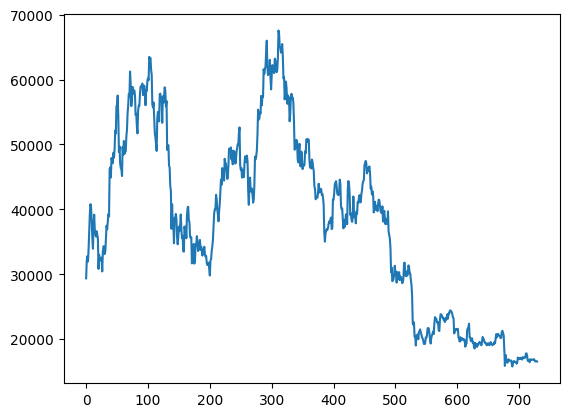

In [ ]:
import matplotlib.pyplot as plt
plt.plot(serie_fechamento)

In [ ]:
X_treino = []
y_treino = []

for i in range(len(serie_fechamento) - 4):
  X_treino.append(serie_fechamento[i:i+3])
  y_treino.append(serie_fechamento[i+4])

X_treino = np.array(X_treino)
y_treino = np.array(y_treino)

X_treino.shape, y_treino.shape

((726, 3), (726,))

In [ ]:
# Exemplo de uso:

def rbf_kernel(X1, X2, gamma=1.0):
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    sq_dists = np.sum(X1**2, axis=1)[:, None] + np.sum(X2**2, axis=1) - 2 * X1 @ X2.T
    return np.exp(-gamma * sq_dists)

preditor, alpha_val, alpha_star_val, alpha_diff_val, b = treinar_svr_dual(X_treino/np.max(X_treino), y_treino/np.max(X_treino), kernel_fn=lambda x, y: rbf_kernel(x,y))

In [ ]:
np.max(X_treino)*preditor(X_treino[0]), y_treino[0]

(np.float64(41263.8823791393), np.float64(33992.4296875))

In [ ]:
np.max(np.abs(alpha_star_val))

np.float64(1.0)

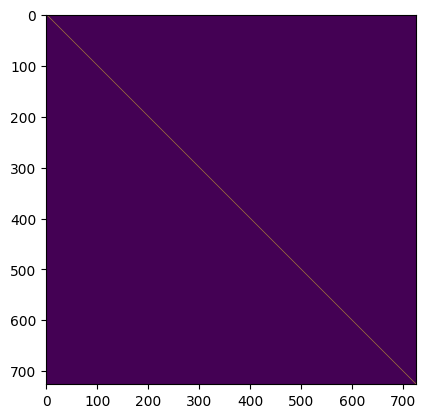

In [ ]:
K = rbf_kernel(X_treino, X_treino)

plt.imshow(K)

In [ ]:
K

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
X_treino

array([[29374.15234375, 32127.26757812, 32782.0234375 ],
       [32127.26757812, 32782.0234375 , 31971.9140625 ],
       [32782.0234375 , 31971.9140625 , 33992.4296875 ],
       ...,
       [16841.98632812, 16919.8046875 , 16717.17382812],
       [16919.8046875 , 16717.17382812, 16552.57226562],
       [16717.17382812, 16552.57226562, 16642.34179688]])

In [ ]:
btc_teste = yf.download("BTC-USD", start="2023-01-02", end="2023-01-10")
y_teste = btc_teste['Close']['BTC-USD'].values
y_teste

[*********************100%***********************]  1 of 1 completed


array([16688.47070312, 16679.85742188, 16863.23828125, 16836.73632812,
       16951.96875   , 16955.078125  , 17091.14453125, 17196.5546875 ])

In [ ]:
np.max(X_treino)*preditor(serie_fechamento[-3:]), y_teste[0]

(np.float64(41263.8823791393), np.float64(16688.470703125))

In [ ]:
serie_fechamento[-1:]

array([16547.49609375])

### Exercício 3: Predição do Próximo Valor do Bitcoin com SVR utilizando janelas de BTC e ETH

Neste exercício, você deve construir um modelo de regressão baseado em SVM (SVR) para prever o **preço de fechamento do Bitcoin no dia 12 de abril de 2025**, utilizando dados dos 10 dias anteriores do próprio Bitcoin **e** também os 10 dias anteriores do Ethereum.

---

**Colher de chá**:

#### Objetivo:

Crie uma função chamada:

```python
def prever_btc_12abril2025():
```

Essa função deve:

1. Baixar os dados históricos de fechamento diário de **Bitcoin (BTC-USD)** e **Ethereum (ETH-USD)** usando `yfinance`;
2. Utilizar os **10 dias anteriores a 12/04/2025** para compor as variáveis preditoras:

   * 10 preços do Bitcoin (`BTC_{t-10}` até `BTC_{t-1}`);
   * 10 preços do Ethereum (`ETH_{t-10}` até `ETH_{t-1}`);
3. Treinar um modelo de **regressão SVM (SVR)** com os dados anteriores (de forma supervisionada);
4. Aplicar o modelo para prever o valor do **Bitcoin no dia 12/04/2025**;
5. Retornar o valor previsto.

---

#### Dicas:

* Utilize a biblioteca `yfinance` para obter os dados:

  ```python
  import yfinance as yf
  btc = yf.download("BTC-USD", start="2021-01-01")
  eth = yf.download("ETH-USD", start="2021-01-01")
  ```

---





In [ ]:
# Solução:

### Exercício 4: Predição de $k$ Próximos Valores do Bitcoin com SVR utilizando janelas de BTC e ETH

Neste exercício, você deve construir um modelo de regressão baseado em SVM (SVR) para prever o **preço de fechamento do Bitcoin em $k$ dias a partir de um dia específico**, utilizando dados dos 10 dias anteriores do próprio Bitcoin **e** também os 10 dias anteriores do Ethereum.


In [ ]:
# Solução:

### Exercício 5: Classificação Multiclasse com SVM

Nos exercícios anteriores, trabalhamos com **classificadores binários** (duas classes apenas) utilizando Máquinas de Vetores de Suporte (SVM).

Agora, seu desafio é **generalizar essa abordagem para problemas com múltiplas classes**.

#### Objetivo:

Implemente uma função chamada `treinar_svm_multiclasse(X, y, C=1.0)` que:

- Treina um modelo SVM **multiclasse** a partir de um conjunto de dados com `k > 2` classes;
- Utiliza apenas um classificador binário como base (ex: como nos exercícios anteriores);
- Retorna um modelo preditivo capaz de classificar **novas amostras** em uma entre `k` classes.

---

#### Dicas:

- Utilize a estratégia **One-vs-Rest (OvR)**:
  - Para cada classe `i`, treine um classificador binário para distinguir “classe `i`” contra “todas as outras”;
  - Para prever uma nova amostra, aplique todos os classificadores e escolha aquele com **maior confiança** (ex: valor do hiperplano mais distante de zero).

---

#### Exemplo de uso esperado:

```python
modelo = treinar_svm_multiclasse(X_train, y_train)
y_pred = modelo(X_test)  # Retorna um vetor com rótulos de múltiplas classes


### Exercício 6: Tipo de floresta com SVM

Repita o exercício 1 com o arquivo `covtype.csv` da base CoverType  (disponível em: https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset/data?select=covtype.csv).